In [1]:
using Revise
using NeutrinoTelescopes
using Plots
using StaticArrays
using DataFrames
using StatsPlots
using LinearAlgebra

using Rotations
using Formatting
using Distributions
import Pipe: @pipe






# Photon Propagation

## Medium Setup
The `MediumProperties` type (and subtypes) hold information about the properties of the medium.
Currently, only properties for Cascadia basin are implemented:
- Scattering length is based on concentration of small / large particls (copied from clsim)
- Absorption length is the STRAW attenuation length (conservative)
- Refractive index is from Quan & Fry (based on salinity, pressure and temperature from cascadia site)
- Density is from DPPIR105
- Radiation length is from PDG

In [2]:
medium = make_cascadia_medium_properties(0.99f0)
material_density(medium), radiation_length(medium)

(1013.2627f0, 36.08f0)

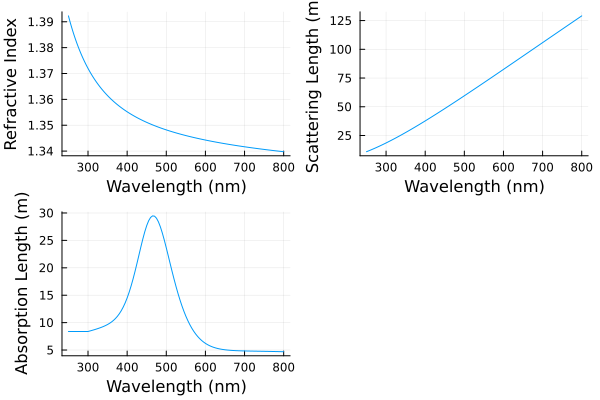

In [3]:
wavelengths = 250.:800 # nm

p1 = plot(wavelengths, refractive_index.(wavelengths, Ref(medium)), xlabel="Wavelength (nm)", ylabel="Refractive Index", label="")
p2 = plot(wavelengths, scattering_length.(wavelengths, Ref(medium)), xlabel="Wavelength (nm)", ylabel="Scattering Length (m)", label="")
p3 = plot(wavelengths, absorption_length.(wavelengths, Ref(medium)), xlabel="Wavelength (nm)", ylabel="Absorption Length (m)", label="")

plot(p1, p2, p3, layout= grid(2, 2))


## Setup Emitter & Target

Here, we define a `MultiPMTDetector` target that is offset from the emitter along the z-axis by `distance`.
The pmt coordinates are supplied by the `make_pom_pmt_coordinates` function. The emitter is defined in two stages:

We define a `Particle`, which is then converted into a `PhotonSource` (`PointlikeCherenkovEmitter` and `ExtendedCherenkovEmitter`).
We can also define more specialized light sources, such as an Axicone or a pencil beam.

In [5]:
distance = 20f0
pmt_area=Float32((75e-3 / 2)^2*π)
target_radius = 0.21f0
target = MultiPMTDetector(@SVector[0.0f0, 0.0f0, distance], target_radius, pmt_area, 
    make_pom_pmt_coordinates(Float32), UInt16(1))

target2 = MultiPMTDetector(@SVector[0.0f0, distance, distance], target_radius, pmt_area, 
    make_pom_pmt_coordinates(Float32), UInt16(2))


zenith_angle = 45f0
azimuth_angle = 0f0

particle = Particle(
        @SVector[0.0f0, 0f0, 0.0f0],
        sph_to_cart(deg2rad(zenith_angle), deg2rad(azimuth_angle)),
        0f0,
        Float32(1E5),
        PEMinus
)

cher_spectrum = CherenkovSpectrum((300f0, 800f0), 30, medium)
mono_spectrum = Monochromatic(405f0)

prop_source_pl = PointlikeCherenkovEmitter(particle, medium, (300f0, 800f0))
prop_source_ext = ExtendedCherenkovEmitter(particle, medium, (300f0, 800f0))
prop_source_axi = AxiconeEmitter(
    @SVector[0.0f0, 0f0, 0.0f0],
    @SVector[0.0f0, 0f0, 1.0f0],
    0f0,
    Int64(1E11),
    deg2rad(40f0))
prop_source_pencil_beam = PencilEmitter(
    @SVector[0.0f0, 0f0, 0.0f0],
    @SVector[0.0f0, 0f0, 1.0f0],
    0f0,
    Int64(1E11)
)


#prop_source_che = PointlikeCherenkovEmitter(particle, medium, (300f0, 800f0))


PencilEmitter{Float32}(Float32[0.0, 0.0, 0.0], Float32[0.0, 0.0, 1.0], 0.0f0, 100000000000)

## Propagate Photons

In [13]:
setup = PhotonPropSetup(prop_source_ext, target, medium, cher_spectrum)
photons = propagate_photons(setup)
photons[1, :]

DataFrameRow
 Row │ position                           direction                          i ⋯
     │ SArray…                            SArray…                            S ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Float32[0.0216106, -0.0519737, 1…  Float32[-0.185684, -0.00307041, …  F ⋯
                                                               5 columns omitted

In [14]:
setup = PhotonPropSetup([prop_source_ext], [target, target2], medium, cher_spectrum)
photons = propagate_photons(setup)
photons[1, :]

DataFrameRow
 Row │ position                           direction                          i ⋯
     │ SArray…                            SArray…                            S ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Float32[0.0216106, -0.0519737, 1…  Float32[-0.185684, -0.00307041, …  F ⋯
                                                               5 columns omitted

## Make Hits From Photons
In order to convert the detected photons into hits, we have to define a module orientation (rotation matrix).
The identity matrix will leave the pmt coordinated unchanged. Hits are the resampled (using the photon weights)

In [54]:
orientation = RotMatrix3(I)
hits = make_hits_from_photons(photons, setup, orientation)
calc_total_weight!(hits, setup)
resampled_hits = resample_simulation(hits)
calc_time_residual!(resampled_hits, setup)
res_grp_pmt = groupby(resampled_hits, [:module_id, :pmt_id]);

GroupedDataFrame with 23 groups based on keys: module_id, pmt_id
First Group (1079 rows): module_id = 1, pmt_id = 1
  Row │ pmt_id  module_id  time     tres     
      │ Int64   Int64      Float32  Float64? 
──────┼──────────────────────────────────────
    1 │      1          1  95.0534   6.61352
    2 │      1          1  91.6293   3.18939
  ⋮   │   ⋮         ⋮         ⋮        ⋮
 1078 │      1          1  91.6934   3.25352
 1079 │      1          1  92.3312   3.89132
                            1075 rows omitted
⋮
Last Group (84 rows): module_id = 2, pmt_id = 16
 Row │ pmt_id  module_id  time     tres     
     │ Int64   Int64      Float32  Float64? 
─────┼──────────────────────────────────────
   1 │     16          2  135.255   9.79382
   2 │     16          2  132.524   7.06256
  ⋮  │   ⋮         ⋮         ⋮        ⋮
  84 │     16          2  138.693  13.231
                             81 rows omitted

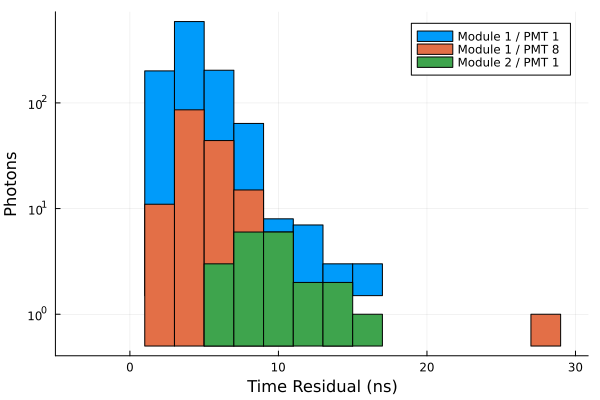

In [68]:
bins = -5:2:30
histogram(res_grp_pmt[(module_id=1, pmt_id=1)][:, :tres], xlabel="Time Residual (ns)", ylabel="Photons", label="Module 1 / PMT 1", yscale=:log10, bins=bins)
histogram!(res_grp_pmt[(module_id=1, pmt_id=8)][:, :tres],  label="Module 1 / PMT 8", yscale=:log10, bins=bins)
histogram!(res_grp_pmt[(module_id=2, pmt_id=1)][:, :tres],  label="Module 2 / PMT 1", yscale=:log10, bins=bins)

In [69]:
plot_hits(target, res_grp_pmt)

UndefVarError: UndefVarError: grid not defined

In [65]:
resampled_hits_pl = @pipe (
    propagate_photons(prop_source_pl, target, medium, cher_spectrum) |>
    make_hits_from_photons(_, prop_source_pl, target, medium, orientation) |>
    resample_simulation(_)
)

MethodError: MethodError: no method matching propagate_photons(::PointlikeCherenkovEmitter{Float32}, ::MultiPMTDetector{Float32, 16, 32}, ::WaterProperties{Float32}, ::CherenkovSpectrum{Float32, CUDA.CuTexture{Float32, 1, CUDA.CuTextureArray{Float32, 1}}})

In [9]:
res_grp_pmt_pl = groupby(resampled_hits_pl, :pmt_id)
p = plot_hits(target, res_grp_pmt, res_grp_pmt_pl, title="Extended vs. Pointlike Emitter")


histogram(res_grp_pmt[1][:, :time], bins=80:1:150, label="Extended", alpha=0.7)
p = histogram!(res_grp_pmt_pl[1][:, :time], bins=80:1:150, label="Pointlike", alpha=0.7, xlabel="Time (ns)", ylabel="Counts")
savefig(p, joinpath(@__DIR__, "../figures/ext_vs_pl_example.png"))


## Simulate Electronics

- Convert detected photons (photons that are converted at the photo cathode) into "charge" - ie. the ampltiude of the resulting PMT pulse.
- Apply the transit time (with TTS) to calculate the pulse time
- Create a PMT pulse by scaling the pulse template with the `charge` and shifting it to the pulse time.
- Sum all pulses to create the waveform
- Digitize the waveform by applying LP filter and discretization



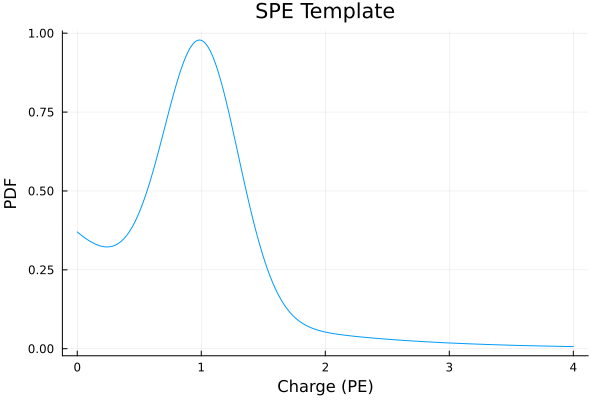

In [10]:
spe_d = make_spe_dist(STD_PMT_CONFIG.spe_template)
xs = 0:0.01:4
plot(xs, pdf.(spe_d, xs), xlabel="Charge (PE)", ylabel="PDF", label="", title="SPE Template")


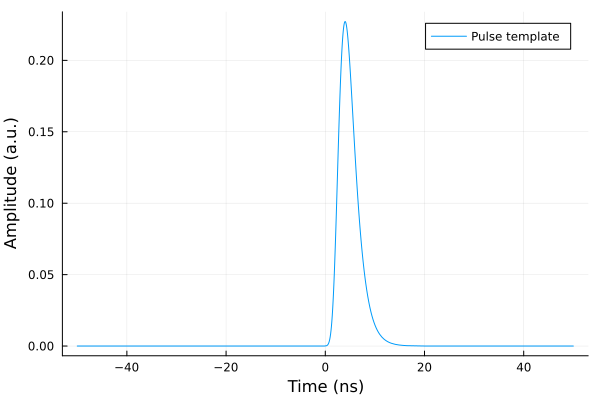

In [11]:
plot(x -> evaluate_pulse_template(STD_PMT_CONFIG.pulse_model, 0.0, x), -50, 50, ylabel="Amplitude (a.u.)", xlabel="Time (ns)", label="Pulse template")


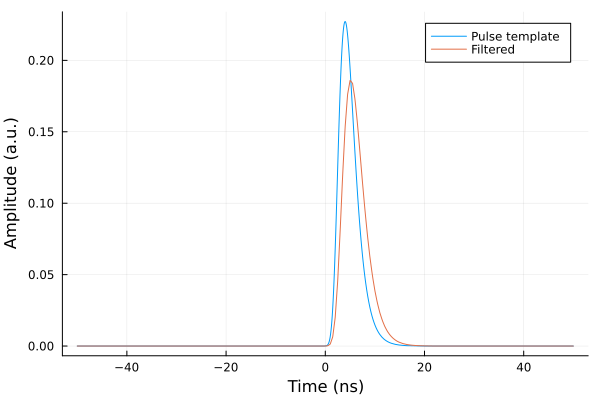

In [12]:
plot!(x -> evaluate_pulse_template(STD_PMT_CONFIG.pulse_model_filt, 0.0, x), -50, 50, label="Filtered")


In [13]:
resampled_hits_tts = copy(resampled_hits; copycols=true)
resampled_hits_tts = subtract_mean_tt!(apply_tt!(resampled_hits_tts, STD_PMT_CONFIG.tt_dist), STD_PMT_CONFIG.tt_dist)


6824×2 DataFrame
  Row │ pmt_id  time    
      │ Int64   Float64 
──────┼─────────────────
    1 │      1  92.8331
    2 │      1  91.5682
    3 │      1  94.0867
    4 │      1  94.2392
    5 │      1  95.2128
    6 │      1  93.2113
    7 │      1  90.4455
    8 │      1  92.3952
  ⋮   │   ⋮        ⋮
 6818 │     16  91.1576
 6819 │     16  92.479
 6820 │     16  92.1298
 6821 │     16  95.0207
 6822 │     16  92.0101
 6823 │     16  92.448
 6824 │     16  92.1824
       6809 rows omitted

In [14]:
pulse_map = map_f_over_pmts(
    target,
    hits -> PulseSeries(hits, STD_PMT_CONFIG.spe_template, STD_PMT_CONFIG.pulse_model),
    groupby(resampled_hits_tts, :pmt_id)
)

wfs = map_f_over_pmts(
    target,
    pulses -> digitize_waveform(
            pulses,
            STD_PMT_CONFIG.sampling_freq,
            STD_PMT_CONFIG.adc_freq,
            STD_PMT_CONFIG.noise_amp,
            STD_PMT_CONFIG.lp_filter
        ),
    pulse_map)

reco_pulses = map_f_over_pmts(
    target,
    wf -> unfold_waveform(
        wf,
        STD_PMT_CONFIG.pulse_model_filt,
        STD_PMT_CONFIG.unf_pulse_res,
        0.2,
        :fnnls),
    wfs)

Dict{Int64, Union{Nothing, PulseSeries{Vector{Float64}, InterpolatedPulse}}} with 16 entries:
  5  => PulseSeries{Vector{Float64}, InterpolatedPulse}([40.7777, 49.2777, 57.2…
  16 => PulseSeries{Vector{Float64}, InterpolatedPulse}([42.0354, 50.0354, 58.0…
  12 => PulseSeries{Vector{Float64}, InterpolatedPulse}([86.5056, 87.0056, 93.0…
  8  => PulseSeries{Vector{Float64}, InterpolatedPulse}([49.9839, 57.9839, 66.4…
  1  => PulseSeries{Vector{Float64}, InterpolatedPulse}([40.994, 49.494, 57.494…
  6  => PulseSeries{Vector{Float64}, InterpolatedPulse}([50.7288, 58.7288, 66.7…
  11 => nothing
  9  => PulseSeries{Vector{Float64}, InterpolatedPulse}([40.4858, 48.9858, 56.9…
  14 => nothing
  3  => PulseSeries{Vector{Float64}, InterpolatedPulse}([58.0735, 93.5735, 98.5…
  7  => nothing
  4  => PulseSeries{Vector{Float64}, InterpolatedPulse}([40.8112, 49.3112, 57.3…
  13 => PulseSeries{Vector{Float64}, InterpolatedPulse}([41.4552, 49.4552, 49.9…
  15 => PulseSeries{Vector{Float64}, Interpolate

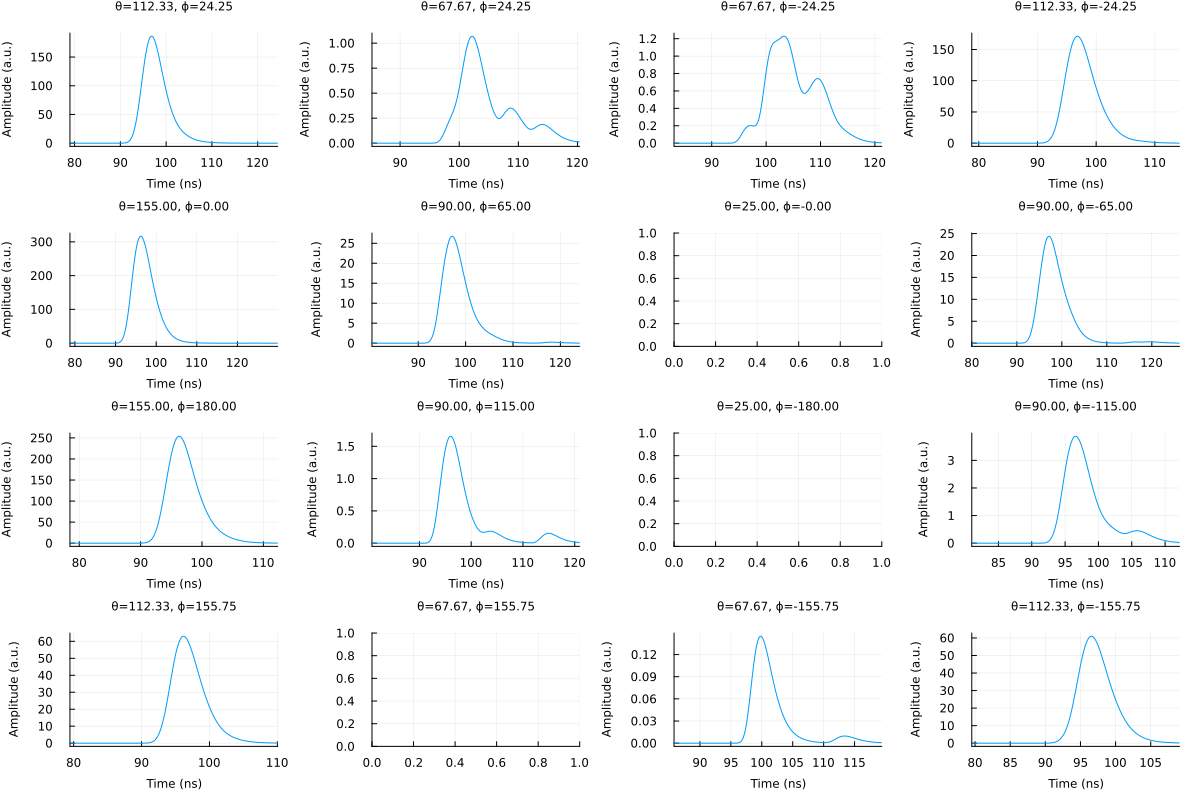

In [16]:
plot_pmt_map(target, pulse_map; labels=("", ), ylabel="Amplitude (a.u.)")

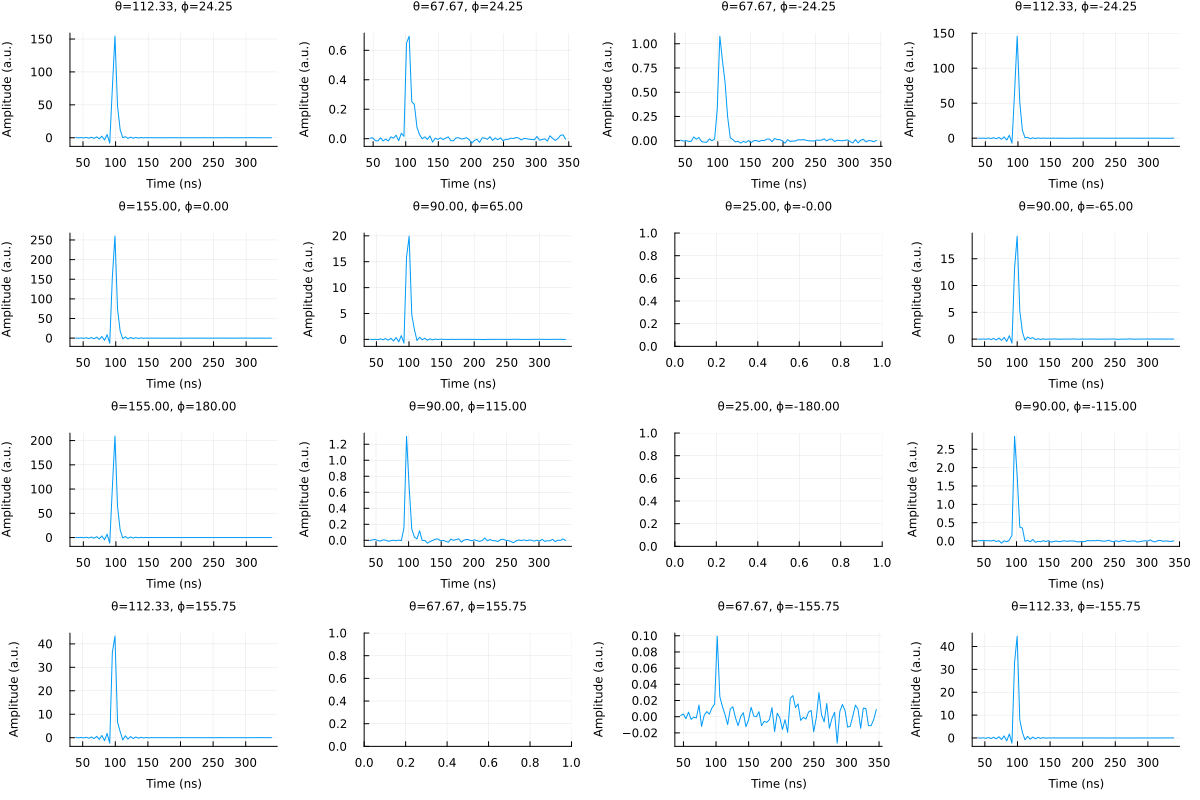

In [17]:
plot_pmt_map(target, wfs; labels=("", ), ylabel="Amplitude (a.u.)")

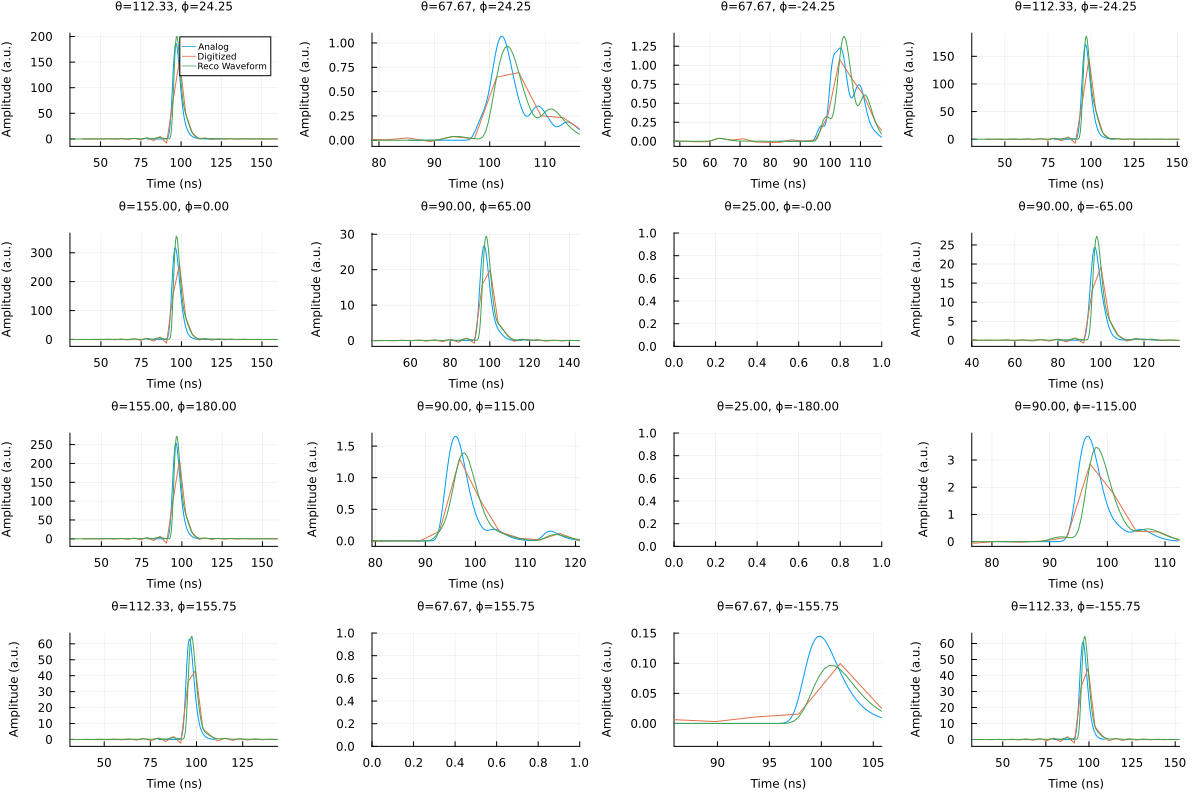

In [34]:
plot_pmt_map(target, pulse_map, wfs, reco_pulses; labels=("Analog", "Digitized", "Reco Waveform"), ylabel="Amplitude (a.u.)")

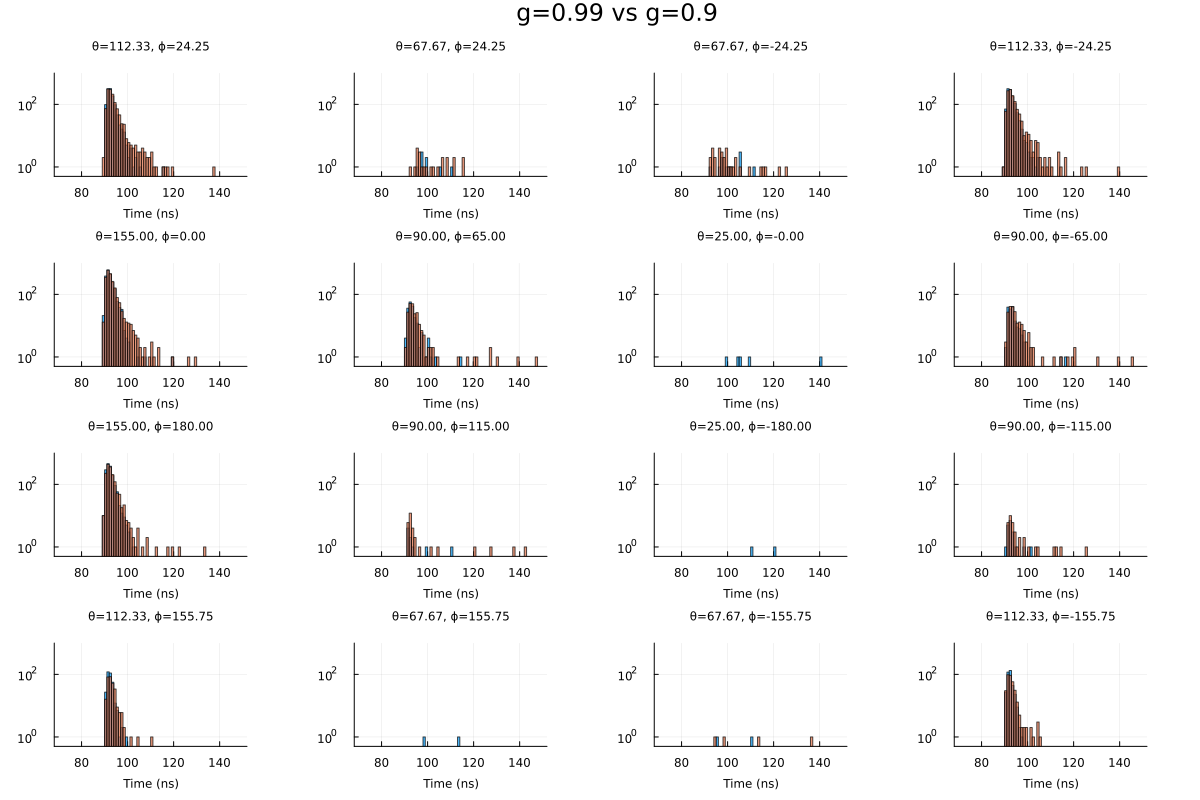

In [35]:
medium2 = make_cascadia_medium_properties(0.9f0)
photons2 = propagate_photons(prop_source_ext, target, medium2, cher_spectrum)
hits2 = make_hits_from_photons(photons2, prop_source_ext, target, medium, orientation)
resampled_hits2 = resample_simulation(hits2)
res_grp_pmt2 = groupby(resampled_hits2, :pmt_id)
plot_hits(target, res_grp_pmt, res_grp_pmt2, title="g=0.99 vs g=0.9")